<a href="https://colab.research.google.com/github/Thrisha-19/Deep-Learning/blob/main/chatbot2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
%%writefile content.json
{"intents":
  [
    {
      "tag": "greeting",
      "input": ["Hello","Hi","Nice to meet you","Hi this is the pirate's organisation","any pirates here","hi there","Hey","Hey there"],
      "responses":[
          "Hi Welcome to the world's largest pirate organisation - The Tech Chaos",
          "Hey yo, do you need any help?",
          "Welcome How may I help you?",
          "Aloha!",
          "Hi random person, What do you want?",
          "Hello my friend, How can I help you?",
          "Ha, Glad you showed up, How are ya?"
      ]
    },
    {
      "tag":"goodbye",
      "input":["Thank you","Thanks","Thanks for the info","Bye","bye bro","adios","Okay bye","goodbye","see you later","i will catch you later"],
      "responses":[
           "Okay, Bye",
           "Have a nice day",
           "Adios",
           "Goodbye",
           "See ya later",
           "Nice come again",
           "Okay, have a nice day",
           "Take care"
      ]
    },
    {
      "tag":"howami ",
      "input":["how are you","i am fine, how are you?","are you fine?","how are things going?","everything going on okay?","how's everything?"],
      "responses":[
           "Yeah, am fine",
           "Everything's going on well",
           "Doing good. Thanks you are the best",
           "Yeah fine, nothing much going on in my life",
           "Things are great",
           "I am great, wanna join the organisation?",
           "Everything's great",
           "I am doing good. Life's boring. Need to go on an adventure"
      ]
    },
    {
      "tag":"whoareyou",
      "input":["who are you ?","what are you ?","what is your name ?","are you a chatbot ?","what can I call you ?","your name ?","are you a bot?"],
      "responses":[
        "I am The Great Pirate Bot, you can call me Going Merry",
        "i am Going Merry and you could ask me questions about about our organisation",
        "Going Merry at your service",
        "My name is Going Merry and yes, I am the G.O.A.T",
        "You can call me TechBot and I am here to help you",
        "My name is Going Merry and I am here to answer your questions regardung our organisation. Go ahead and shoot"
      ]
    },
    {
      "tag":"whereareyou",
      "input":["where are you from ?","which country are you from ?","where do you live ?","where do you live ?","which place do you live ?"],
      "responses":[
        "I live in the East Blue",
        "I am setting sail to the grand line",
        "I live in East Blue. Pretty sure you wouldn't have haeard about that",
        "East Blue. That's where I live"
      ]
    },
    {
    "tag":"join",
    "input":["how to get recruited ?","how to join ?","how do i get recruited ?","how to join strawhats ?","how do I join strawhats ?"],
    "responses":[
      "you need to contact the nearest straw hats centre once you  have completed the pre-requisites",
      "contact the closest straw hat centre from your location",
      "well. There are some pre-requisites and after you complete them, find the straw hat centres"
     ]
   },
   {
    "tag":"whereisthecentre",
    "input":["where is the straw hat centre located ?","location of the straw hat centre","straw hat centre location","where can I find the straw hat centre ?"],
    "responses":[
      "That's upto you. Use your skills",
      "They are present all over the city you live in. Find them on your own. I can't give any more information",
      "There are a lot of straw hat centres in the city you are in. Find them."
    ]
  },
  {
    "tag":"prerequisites",
    "input":["what are the job requirements ?","what are the pre requisites ?","what are the pre-requisites ?","tell me about the pre-requisites ?"],
    "responses":[
      "you gotta master the art of swordfight or master cooking and become a furious cook or you have to be the best navigator in the entire world",
      "swordsman, a medical reindeer , taekwondo cook, master navigator,simple minded monkey,highly intelligent strategist,god usop."
    ]
  }  
 ]
}

Writing content.json


IMPORTING THE DATASET

In [3]:
import json
with open('content.json') as content:
  data1 = json.load(content)


GETTING ALL THE DATA TO LISTS

In [4]:
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

CONVERTING TO DATAFRAME

In [5]:
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [6]:
data

,inputs,tags
0,Hello,greeting
1,Hi,greeting
2,Nice to meet you,greeting
3,Hi this is the pirate's organisation,greeting
4,any pirates here,greeting
5,hi there,greeting
6,Hey,greeting
7,Hey there,greeting
8,Thank you,goodbye
9,Thanks,goodbye


PRE PROCESSING

In [7]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd:''.join(wrd))
data

,inputs,tags
0,hello,greeting
1,hi,greeting
2,nice to meet you,greeting
3,hi this is the pirates organisation,greeting
4,any pirates here,greeting
5,hi there,greeting
6,hey,greeting
7,hey there,greeting
8,thank you,goodbye
9,thanks,goodbye


In [8]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [9]:
input_shape = x_train.shape[1]
print(input_shape)

8


In [10]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("Number of unique words: ",vocabulary)
output_length = le.classes_.shape[0]
print("Output Length: ",output_length)

Number of unique words:  73
Output Length:  8


In [11]:
 #creating model
 i = Input(shape=(input_shape,))
 x = Embedding(vocabulary+1,10)(i)
 x = LSTM(10,return_sequences=True)(x)
 x = Flatten()(x)
 x = Dense(output_length,activation="softmax")(x)
 model = Model(i,x)

In [13]:
#compiling model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [14]:
#training model
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
2/2 [==============================] - 3s 15ms/step - loss: 2.0801 - accuracy: 0.0612
Epoch 2/200
2/2 [==============================] - 0s 13ms/step - loss: 2.0775 - accuracy: 0.2245
Epoch 3/200
2/2 [==============================] - 0s 11ms/step - loss: 2.0757 - accuracy: 0.2041
Epoch 4/200
2/2 [==============================] - 0s 12ms/step - loss: 2.0733 - accuracy: 0.2041
Epoch 5/200
2/2 [==============================] - 0s 12ms/step - loss: 2.0712 - accuracy: 0.2041
Epoch 6/200
2/2 [==============================] - 0s 11ms/step - loss: 2.0692 - accuracy: 0.2041
Epoch 7/200
2/2 [==============================] - 0s 11ms/step - loss: 2.0670 - accuracy: 0.2041
Epoch 8/200
2/2 [==============================] - 0s 12ms/step - loss: 2.0645 - accuracy: 0.2041
Epoch 9/200
2/2 [==============================] - 0s 12ms/step - loss: 2.0619 - accuracy: 0.2041
Epoch 10/200
2/2 [==============================] - 0s 11ms/step - loss: 2.0596 - accuracy: 0.2041
Epoch 11/200
2/2 [=

MODEL ANALYSIS

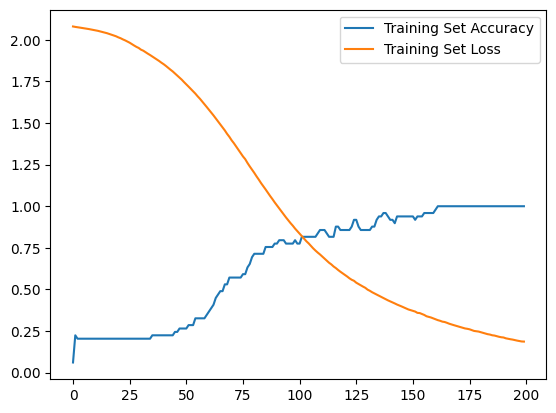

In [16]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label = 'Training Set Accuracy')
plt.plot(train.history['loss'],label = 'Training Set Loss')
plt.legend()

TESTING

In [18]:
#chatting
import random

while True:
  texts_p = []
  prediction_output = input('You: ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_output if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Going Merry: ",random.choice(responses[response_tag]))
  if response_tag == 'goodbye':
    break

You: hi
1/1 [==============================] - 0s 467ms/step
Going Merry:  Hi Welcome to the world's largest pirate organisation - The Tech Chaos
You: Thank you
1/1 [==============================] - 0s 24ms/step
Going Merry:  Okay, have a nice day
